In [69]:
import os
import cooler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
def extract_tss_from_bed(bed_file, genes_of_interest):
    """从 BED 文件提取目标基因的 TSS 位点"""
    tss_list = []
    with open(bed_file, "r") as f:
        for line in f:
            cols = line.strip().split("\t")
            chrom, start, end, gene = cols[0], int(cols[1]), int(cols[2]), cols[5]
            if gene in genes_of_interest:
                tss_list.append((chrom, start, end, gene))
    return tss_list

# **输入参数**
bed_file = "hg38.genecode.promoter.selected.2k5bp.bed"  # BED 文件
genes_of_interest = ["MAPT", "CRHR1", "KANSL1"]  # 目标基因

# **提取 TSS**
tss_list = extract_tss_from_bed(bed_file, genes_of_interest)

# **查看提取结果**
pd.DataFrame(tss_list, columns=["Chromosome", "Start", "End", "Gene"])


,Chromosome,Start,End,Gene
0,chr17,45781780,45786780,CRHR1
1,chr17,45891882,45896882,MAPT
2,chr17,46222889,46227889,KANSL1


In [71]:
def extract_hic_contact(cool_path, chrom, start, end, res):
    """从 .mcool 文件提取 Hi-C 矩阵"""
    c = cooler.Cooler(f"{cool_path}::/resolutions/{res}")
    row_bin_start = (start // res) * res  # 计算 bin 位置
    left = max(0, row_bin_start - 250000)  # 向左扩展 500kb
    right = row_bin_start + 250000         # 向右扩展 500kb
    
    # 提取 Contact Matrix
    mat_chr = c.matrix(balance=False, sparse=False).fetch((chrom, left, right))
    np.nan_to_num(mat_chr, copy=False)

    # 取目标 TSS bin 对应的 Contact Frequency
    row_index = (250000 // res)
    row_values = mat_chr[row_index, :] / mat_chr[row_index, row_index]
    row_values = row_values.tolist()

    # 计算基因组坐标
    genomic_coords = np.arange(left, right, res)

    return genomic_coords, row_values

In [72]:
def plot_virtual_4C(tss_list, cell_lines, res):
    """为每个基因和细胞类型分别绘制 Genome1 vs Genome2 的 Hi-C Contact Frequency"""
    # 解析不同细胞类型（基于前缀）
    cell_types = set(["_".join(cell.split("_")[:1]) for cell in cell_lines])  # Astro, Neuro, Oligo

    for chrom, start, end, gene in tss_list:
        for cell_type in cell_types:
            g1_file = f"{cell_type}_merged_chr17.genome1.balanced.mapq30.dedup.mcool"
            g2_file = f"{cell_type}_merged_chr17.genome2.mapq30.dedup.mcool"

            # 确保 Genome1 和 Genome2 都存在
            if not os.path.exists(g1_file) or not os.path.exists(g2_file):
                print(f"WARNING: {g1_file} 或 {g2_file} 不存在，跳过 {cell_type} - {gene}")
                continue

            # 获取 Hi-C Contact 数据
            genomic_coords_g1, contact_freqs_g1 = extract_hic_contact(g1_file, chrom, start, end, res)
            genomic_coords_g2, contact_freqs_g2 = extract_hic_contact(g2_file, chrom, start, end, res)

            # **画图**
            plt.figure(figsize=(10, 6))
            plt.plot(genomic_coords_g1, contact_freqs_g1, label=f"{cell_type} Genome1", alpha=0.7, color="blue")
            plt.plot(genomic_coords_g2, contact_freqs_g2, label=f"{cell_type} Genome2", alpha=0.7, color="red")

            # **格式化图像**
            plt.xlabel("Genomic Position (bp)", fontsize=12)
            plt.ylabel("Hi-C Contact Frequency", fontsize=12)
            plt.title(f"Virtual 4C - {gene} in {cell_type}", fontsize=14, fontweight="bold")
            plt.ylim(-0.01,1)
            plt.legend()
            plt.show()


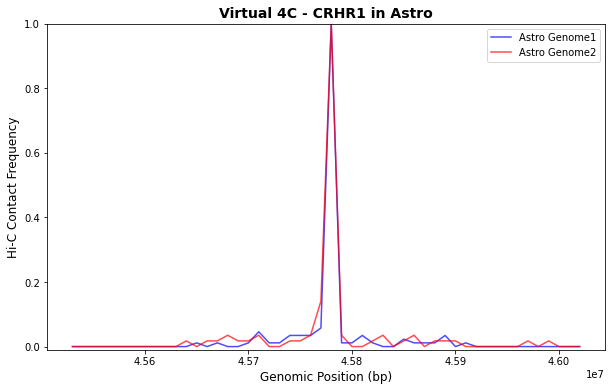

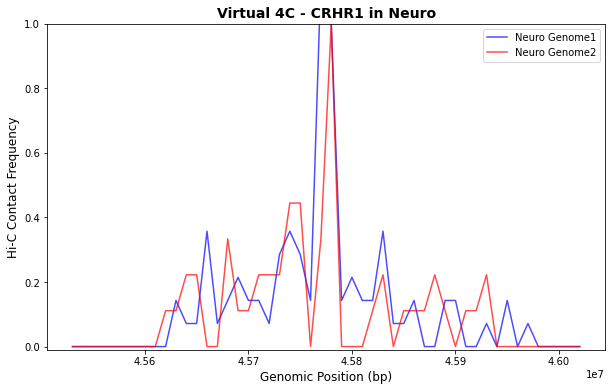

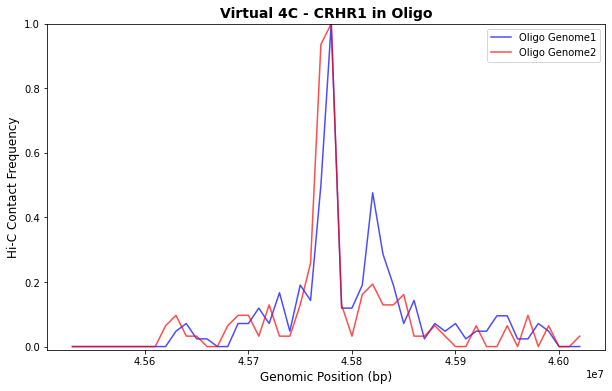

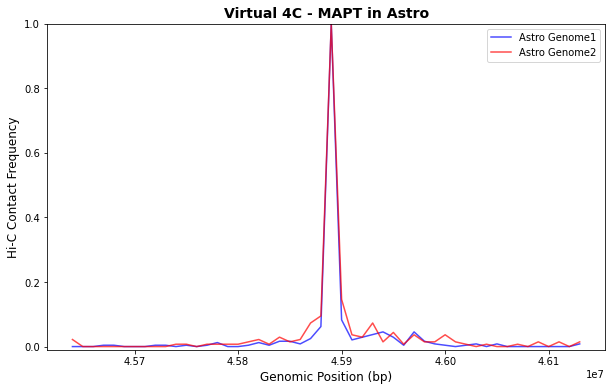

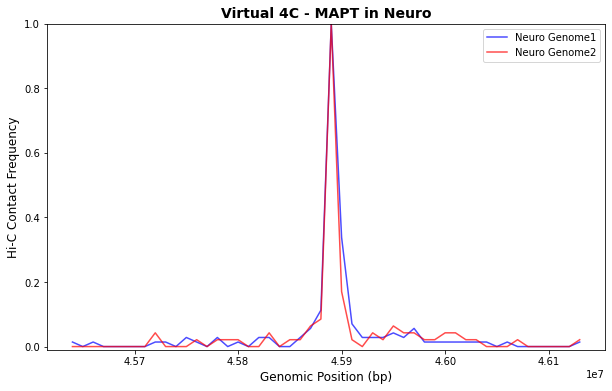

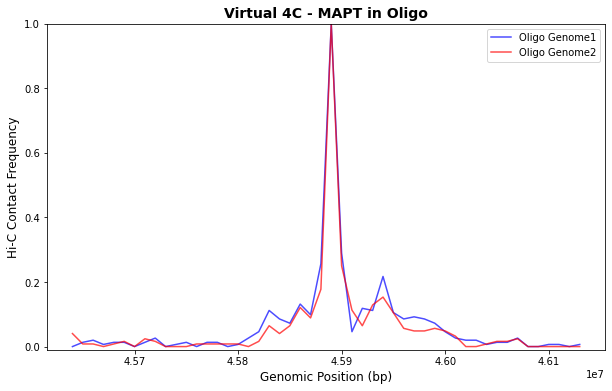

In [73]:
bed_file = "hg38.genecode.promoter.selected.2k5bp.bed"
genes_of_interest = ["MAPT", "CRHR1"]

cell_lines = [
    "Astro_merged_chr17.genome1.balanced.mapq30.dedup",
    "Astro_merged_chr17.genome2.mapq30.dedup",
    "Neuro_merged_chr17.genome1.balanced.mapq30.dedup",
    "Neuro_merged_chr17.genome2.mapq30.dedup",
    "Oligo_merged_chr17.genome1.balanced.mapq30.dedup",
    "Oligo_merged_chr17.genome2.mapq30.dedup"
]

# **提取目标基因的 TSS**
tss_list = extract_tss_from_bed(bed_file, genes_of_interest)

# **绘制 Hi-C Contact Frequency**
plot_virtual_4C(tss_list, cell_lines, 10000)